# Fixed-Income Analysis

## Statistical Analysis

This section explores how interest rates, inflation, and other macroeconomic indicators affect bond prices and yields.

In [4]:
# Import necessary libraries
import api_keys
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import datetime as dt
from fredapi import Fred
from scipy.optimize import root
from sklearn.linear_model import LinearRegression
from pylab import mpl, plt

In [5]:
# Notebook settings
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(0)
%matplotlib inline

In [6]:
# Create Fred object to access data
fred = Fred(api_keys.api_key)

In [7]:
# Retrieve macroeconomic data
start = '1/1/2005'
gdp = fred.get_series('GDP', observation_start=start) # quarterly
fed_funds_rate = fred.get_series('FEDFUNDS', observation_start=start) # monthly
core_cpi = fred.get_series('CPILFESL', observation_start=start) # monthly
unrate = fred.get_series('UNRATE', observation_start=start) # monthly

In [8]:
# Calculate recessionary periods
gdp_change = gdp.pct_change() * 100
recession = (gdp_change < 0).rolling(2).sum() == 2
recession = recession[recession]
recession

2009-01-01    True
2009-04-01    True
2020-04-01    True
dtype: bool

In [9]:
# Format for plotting on time series
dates = pd.Series({dt.datetime(2008, 10, 1): True, dt.datetime(2020, 1, 1): True})
recession = pd.concat([recession, dates])
recession = recession.sort_index()
recession

2008-10-01    True
2009-01-01    True
2009-04-01    True
2020-01-01    True
2020-04-01    True
dtype: bool

In [10]:
# Create dataframe
macro_data = pd.concat([fed_funds_rate, core_cpi, unrate], axis=1)
macro_data.columns = ['ffr', 'cpi', 'unrate']
macro_data

,ffr,cpi,unrate
2005-01-01,2.28,199.000,5.3
2005-02-01,2.50,199.400,5.4
2005-03-01,2.63,200.100,5.2
2005-04-01,2.79,200.200,5.2
2005-05-01,3.00,200.500,5.1
...,...,...,...
2024-06-01,5.33,318.346,4.1
2024-07-01,5.33,318.872,4.3
2024-08-01,5.33,319.768,4.2
2024-09-01,5.13,320.767,4.1


In [11]:
# Statistical summary
macro_data.describe()

,ffr,cpi,unrate
count,238.000000,238.000000,238.000000
mean,1.662017,245.834231,5.830672
std,1.934200,32.330575,2.143980
min,0.050000,199.000000,3.400000
25%,0.120000,220.682250,4.100000
50%,0.400000,239.521000,5.000000
75%,2.750000,265.338250,7.450000
max,5.330000,321.666000,14.800000


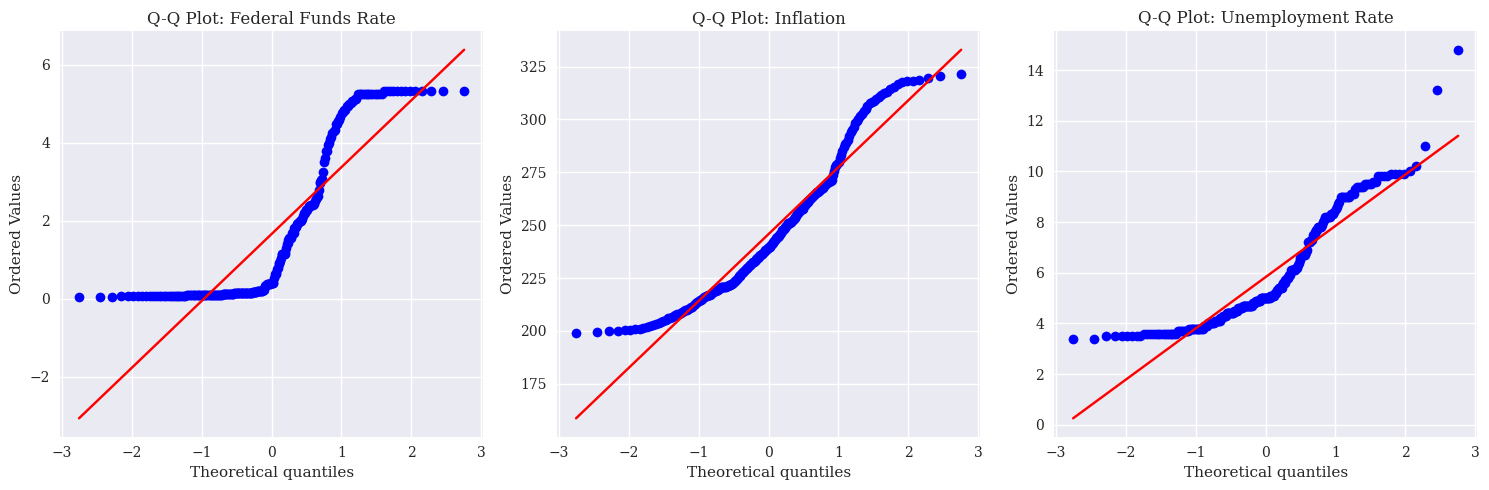

In [12]:
# Plot distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

stats.probplot(macro_data['ffr'], dist='norm', plot=axes[0])
axes[0].set_title('Q-Q Plot: Federal Funds Rate')
axes[0].grid(True)

stats.probplot(macro_data['cpi'], dist='norm', plot=axes[1])
axes[1].set_title('Q-Q Plot: Inflation')
axes[1].grid(True)

stats.probplot(macro_data['unrate'], dist='norm', plot=axes[2])
axes[2].set_title('Q-Q Plot: Unemployment Rate')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [13]:
# Retrieve bond yields
two_yr_treasury = fred.get_series('DGS2', observation_start=start)
ten_yr_treasury = fred.get_series('DGS10', observation_start=start)

In [14]:
# Resample to monthly periods
two_yr_treasury = two_yr_treasury.resample('MS').mean()
ten_yr_treasury = ten_yr_treasury.resample('MS').mean()

In [15]:
# Create dataframe
bond_yields = pd.concat([two_yr_treasury, ten_yr_treasury], axis=1)
bond_yields.columns = ['2yr', '10yr']
bond_yields = bond_yields.drop(index='2024-11-01')
bond_yields

,2yr,10yr
2005-01-01,3.222500,4.221500
2005-02-01,3.384737,4.165263
2005-03-01,3.726818,4.497727
2005-04-01,3.653810,4.340952
2005-05-01,3.643810,4.144286
...,...,...
2024-06-01,4.736842,4.305263
2024-07-01,4.495909,4.248636
2024-08-01,3.965455,3.870909
2024-09-01,3.622500,3.723500


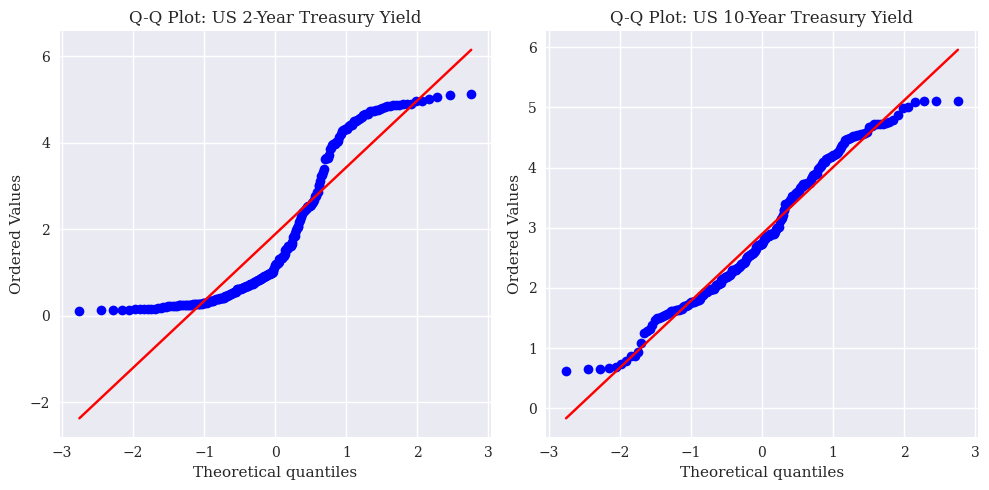

In [16]:
# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

stats.probplot(bond_yields['2yr'], dist='norm', plot=axes[0])
axes[0].set_title('Q-Q Plot: US 2-Year Treasury Yield')
axes[0].grid(True)

stats.probplot(bond_yields['10yr'], dist='norm', plot=axes[1])
axes[1].set_title('Q-Q Plot: US 10-Year Treasury Yield')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [17]:
# Regress US 2-year treasury yields on macroeconomic data
X = macro_data
Y = bond_yields['2yr']
lm = LinearRegression()
lm.fit(X, Y)
yhat = lm.predict(X)
print(f'{lm.score(X, Y):.2%} of the variation in the 2-year treasury yield is explained by the macroeconomic data.')

93.00% of the variation in the 2-year treasury yield is explained by the macroeconomic data.


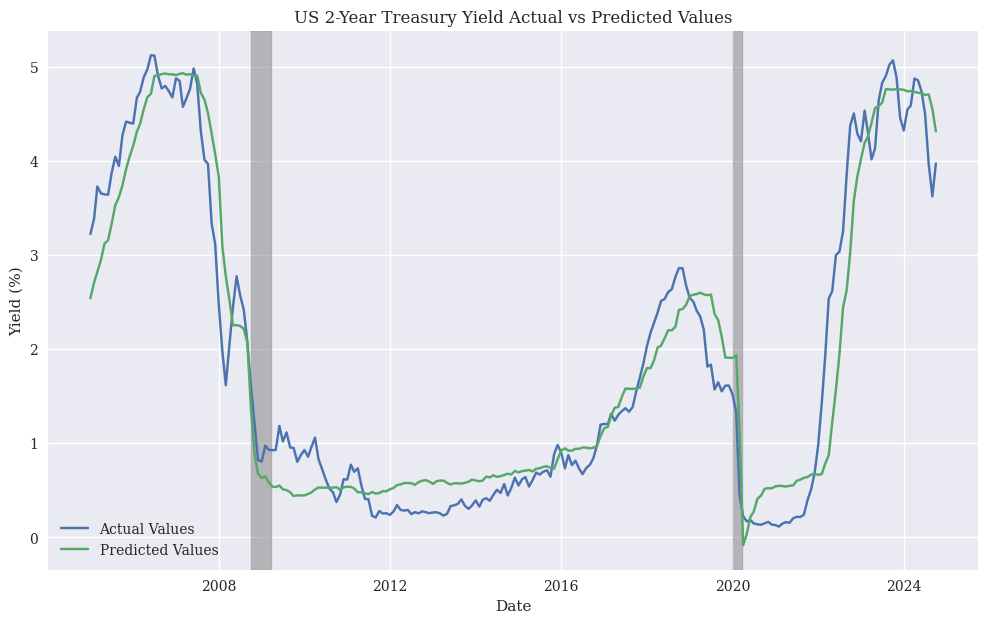

In [18]:
# Plot actual and predicted values
plt.figure(figsize=(12, 7))
plt.plot(X.index, Y, label='Actual Values')
plt.plot(X.index, yhat, label='Predicted Values')

# Shade recessions
plt.axvspan(recession.index[0], recession.index[2], color='gray', alpha=0.5)
plt.axvspan(recession.index[3], recession.index[4], color='gray', alpha=0.5)

# Format time series
plt.title('US 2-Year Treasury Yield Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend(loc=0)
plt.show()

In [19]:
# Regress US 10-year treasury yields on macroeconomic data
X = macro_data
Y = bond_yields['10yr']
lm = LinearRegression()
lm.fit(X, Y)
yhat = lm.predict(X)
print(f'{lm.score(X, Y):.2%} of the variation in the 10-year treasury yield is explained by the macroeconomic data.')

74.58% of the variation in the 10-year treasury yield is explained by the macroeconomic data.


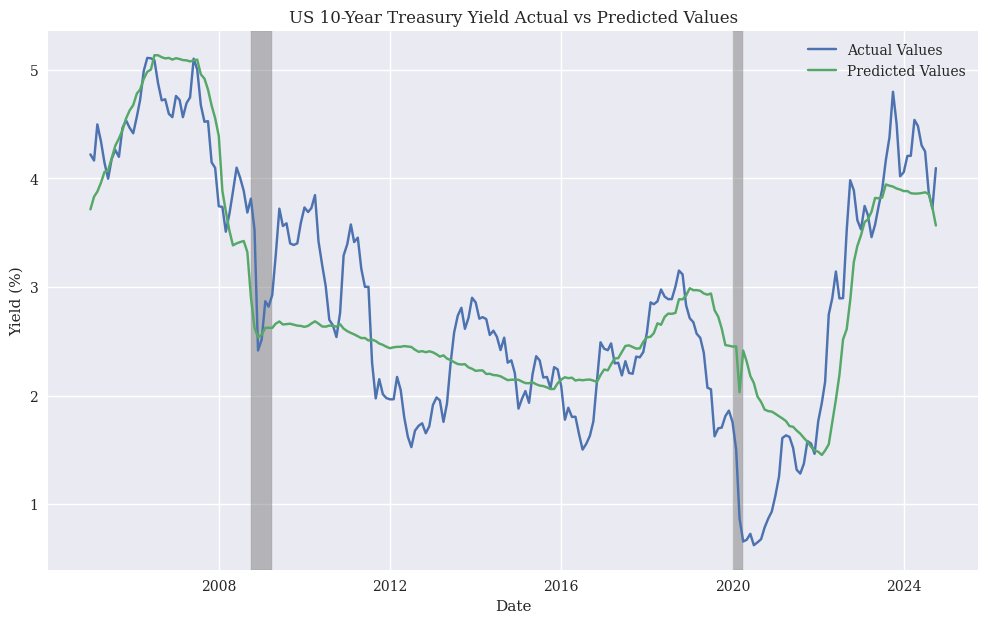

In [20]:
# Plot actual and predicted values
plt.figure(figsize=(12, 7))
plt.plot(X.index, Y, label='Actual Values')
plt.plot(X.index, yhat, label='Predicted Values')

# Shade recessions
plt.axvspan(recession.index[0], recession.index[2], color='gray', alpha=0.5)
plt.axvspan(recession.index[3], recession.index[4], color='gray', alpha=0.5)

# Format time series
plt.title('US 10-Year Treasury Yield Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend(loc=0)
plt.show()

## Bond Portfolio

This section allows the user to construct a bond portfolio according to the desired risk and return profile.

In [23]:
class Bond():
    '''
    Represents a bond object.
    Assumes a par value of $1000.
    '''
    
    def __init__(self, name, price, coupon, maturity, frequency=1, par=1000.):
        self.name = name
        self.__price = price
        self.__coupon = coupon
        self.__maturity = maturity
        self.__frequency = frequency
        self.__par = par
        
    def __repr__(self):
        return f'''
        Name: {self.name}, Price: ${self.__price:.2f}
        Coupon Rate: {self.__coupon:.2%}, YTM: {self.get_ytm():.2%}
        Maturity: {self.__maturity} years, Duration: {self.get_duration():.2f} years
        '''
        
    def get_name(self):
        return self.name
    
    def get_price(self):
        return self.__price

    def get_coupon(self):
        return self.__coupon

    def get_maturity(self):
        return self.__maturity

    def get_frequency(self):
        return self.__frequency

    def get_ytm(self):
        '''
        Calculates the yield to maturity for the bond.
        '''
        coupon = self.__coupon * self.__par / self.__frequency
        periods = self.__maturity * self.__frequency

        def price_diff(ytm):
            bond_price = sum([coupon / (1 + ytm / self.__frequency) ** period for period in range(1, periods + 1)]) + self.__par / (1 + ytm / self.__frequency) ** periods
            return self.__price - bond_price

        bond_yield = root(price_diff, 0).x[0]
        return bond_yield

    def get_duration(self):
        '''
        Calculates the Macaulay duration for the bond.
        '''
        
        coupon = self.__coupon * self.__par / self.__frequency
        ytm = self.get_ytm() / self.__frequency
        periods = self.__maturity * self.__frequency
    
        coupon_payments = pd.Series([coupon] * periods)
        coupon_payments.iloc[-1] += self.__par
        periods = pd.Series(range(1, periods + 1))
        
        pv_cashflow = coupon_payments / (1 + ytm) ** periods
        weights = pv_cashflow / pv_cashflow.sum()
        duration = (periods * weights).sum() / self.__frequency
        
        return duration

In [24]:
mid_bond = Bond('t-bill', 1000, 0.032, 5, 2)
print(mid_bond)


        Name: t-bill, Price: $1000.00
        Coupon Rate: 3.20%, YTM: 3.20%
        Maturity: 5 years, Duration: 4.66 years
        


In [25]:
class Portfolio():
    '''
    Represents a portfolio object.
    '''

    def __init__(self):
        self.__bonds = []

    def get_constituents(self):
        return self.__bonds

    def add_bond(self, bond, weight):
        self.__bonds.append((bond, weight))

    def portfolio_return(self):
        return sum(bond.get_ytm() * weight for bond, weight in self.__bonds)

    def portfolio_risk(self):
        return sum(bond.get_duration() * weight for bond, weight in self.__bonds)

    def plot_allocation(self):
        '''
        Plots a pie chart for the portfolio.
        '''
        
        names = []
        weights = []
        for bond in self.__bonds:
            names.append(bond[0].get_name())
            weights.append(bond[1])
     
        plt.figure(figsize=(12, 7))
        plt.pie(weights, labels=names, autopct='%1.1f%%', startangle=140)
        plt.title('Portfolio Allocation by Bond')
        plt.show()

    def maturity_timeline(self):
        '''
        Plots a maturity timeline for bonds in the portfolio.
        '''
        names = []
        maturities = []
        for bond in self.__bonds:
            names.append(bond[0].get_name())
            maturities.append(bond[0].get_maturity())
        
        plt.figure(figsize=(12, 7))
        plt.barh(names, maturities, color='teal')
        plt.title('Bond Maturity Timeline')
        plt.xlabel('Year of Maturity')
        plt.ylabel('Bond')
        plt.grid(axis='x')
        plt.show()

In [26]:
# Generate random bonds
def generate_random_bonds(num_of_bonds):
    '''
    Generates random bond objects.
    '''
    
    bonds = []
    for i in range(num_of_bonds):
        if i < 3:
            maturity = np.random.randint(1, 3)
            coupon = np.random.uniform(0.01, 0.03)  # Lower coupon for short maturities
            price = np.random.uniform(980, 1020)
        elif i < 6:
            maturity = np.random.randint(4, 7)
            coupon = np.random.uniform(0.03, 0.05)
            price = np.random.uniform(950, 1050)
        else:
            maturity = np.random.randint(8, 30)
            coupon = np.random.uniform(0.05, 0.08)  # Higher coupon for longer maturities
            price = np.random.uniform(900, 1050)
        
        bond = Bond(name=f'Bond {i+1}', price=price, coupon=coupon, maturity=maturity)
        bonds.append(bond)
    
    return bonds

In [27]:
bonds = generate_random_bonds(9)
bonds[0]


        Name: Bond 1, Price: $1013.77
        Coupon Rate: 2.19%, YTM: 0.80%
        Maturity: 1 years, Duration: 1.00 years
        

In [28]:
# Add bonds to portfolio
bond_portfolio = Portfolio()
weights = np.random.rand(len(bonds), 1)
weights = (weights / weights.sum()).flatten().tolist()

for bond, weight in zip(bonds, weights):
    bond_portfolio.add_bond(bond, weight)

# Calculate return and duration
print(bond_portfolio.portfolio_return())
print(bond_portfolio.portfolio_risk())

0.04116383462239773
4.292656756328657


In [29]:
bond_portfolio.get_constituents()[1]

(
         Name: Bond 2, Price: $996.95
         Coupon Rate: 2.09%, YTM: 2.25%
         Maturity: 2 years, Duration: 1.98 years
         ,
 0.14875186826356554)

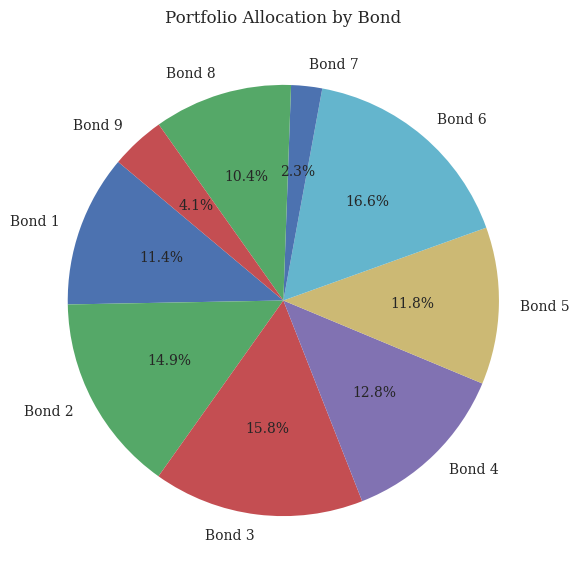

In [30]:
bond_portfolio.plot_allocation()

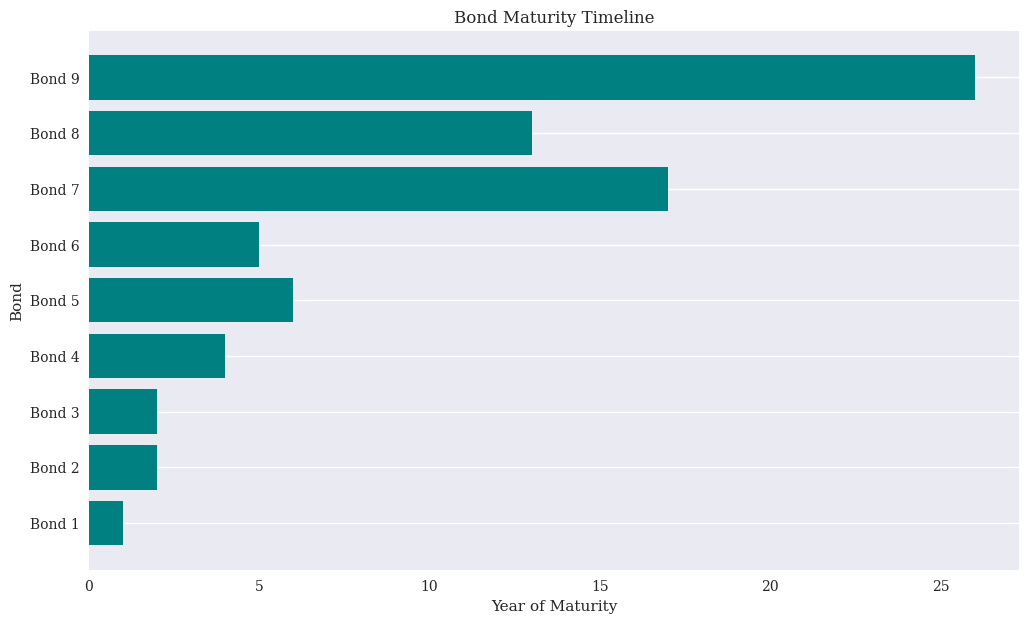

In [31]:
bond_portfolio.maturity_timeline()

In [32]:
# https://stackoverflow.com/questions/17001389/pandas-resample-documentation